# Deep learning tests

## Load libraries and data

In [2]:
import scipy.io as scio
from scipy.interpolate import CubicSpline
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.linear_model
import torch
import torch.nn
import torch.nn.functional
import torch.utils.data
import tqdm
from torchvision import datasets, transforms

data = scio.loadmat('tissue14.mat')
calibration = scio.loadmat('cal_14.mat')

In [ ]:
# Look at imported data
for key, value in data.items():
    try:
        print(key, value.shape)
    except:
        print(key, len(value))

In [3]:
target = data['tissue_t14_2']
tissue_data = data['map_t14_2'] 

target_simple = target.copy()
for i in range(200):
    for j in range(200):
        if target[i,j] == 2:
            target_simple[i,j]=1
        if target[i,j] == 3:
            target_simple[i,j]=2
        if target[i,j] == 5:
            target_simple[i,j]=3
        if target[i,j] == 6:
            target_simple[i,j]=4
        if target[i,j] == 8:
            target_simple[i,j]=5

## Create simple fake data 

In [5]:
fake_data = tissue_data.copy()

In [26]:
import random 
p = 0.8

for i in range(200):
    for j in range(200):
        this_spectra = np.zeros(1024)

        for k in range(64):
            if random.random() < p:
                this_spectra[k] = target_simple[i,j]
            else:
                this_spectra[k] = random.randint(0,5)
        
        fake_data[i,j,:] = this_spectra

In [27]:
square_fake_data = []
for i in range(200):
    for j in range(200):
        this = []
        for m in range(8):
            this.append(fake_data[i,j,m*8:(m+1)*8])
        square_fake_data.append(this)

## Get 5x5 sub-images

In [7]:
sub_images_5 = []  # 196^2 x 25 x 128
target_5 = np.zeros((196,196))

for i in range(196):
    for j in range(196):
        sub_images = fake_data[i:i+5, j:j+5,0:128]  # 5 x 5 x 128
        this_sample = []
        
        for m in range(5):
            for n in range(5):
                this_sample.append(sub_images[m,n,:])

        target_5[i,j] = target_simple[i+2,j+2]
        sub_images_5.append(this_sample)

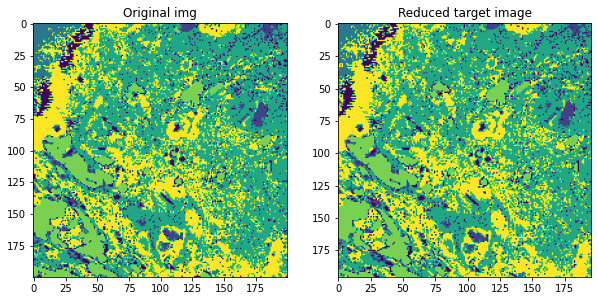

In [18]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(target_simple)
axs[0].title.set_text('Original img')

axs[1].imshow(target_5)
axs[1].title.set_text('Reduced target image')


## Convolutional neural network

In [32]:
X = square_fake_data # 40k x 8 x 8 

y = []
for i in range(200):
    for j in range(200):
        y.append(target_simple[i,j])

In [64]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.2, shuffle=False)

In [65]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,5,kernel_size=3,padding='same') 
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(2, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(5,10,kernel_size=3,padding='same') 
        self.relu2 = torch.nn.ReLU()

        self.flat = torch.nn.Flatten(1)
        self.drop = torch.nn.Dropout(p=0.2)

        self.fc1 = torch.nn.Linear(250, 100)
        self.relu3 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(100, 6)
        self.softmax = torch.nn.Softmax(dim=1)  
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.conv2(output)
        #output = self.relu2(output)
    
        output = self.flat(output)
        output = self.drop(output)
        
        output = self.fc1(output)
        output = self.relu3(output)
        output = self.fc3(output)
        output = self.softmax(output)
        return output

In [66]:
model = ConvolutionalNeuralNetwork()
learning_rate = 0.1
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss() 

model.train();

In [67]:
tensor_X_train = torch.Tensor(X_train).reshape(32000,1,8,8)
tensor_y_train = torch.Tensor(y_train).long()

tensor_X_test = torch.Tensor(X_test).reshape(8000,1,8,8)
tensor_y_test = torch.Tensor(y_test).long()

In [68]:
dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_y_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size = 10000, shuffle=True, num_workers=0)

In [69]:
loss_history = []
accuracy_history = []
for epoch in tqdm.trange(num_epochs):
    for i, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


Text(0, 0.5, 'loss')

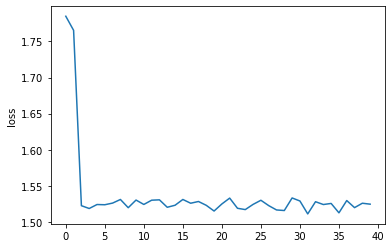

In [70]:
plt.figure()
plt.plot(loss_history)
plt.ylabel('loss')

### Let's see how the model does...

In [71]:
model.eval();

y_pred_train = model(tensor_X_train) # 32000
y_pred_test = model(tensor_X_test)   #  8000

In [72]:
results = []

for item in y_pred_train:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)

for item in y_pred_test:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)
    
approximation = np.zeros((196,196))
for i in range(196):
    for j in range(196):
        index = i*196 + j
        approximation[i,j] = results[index]

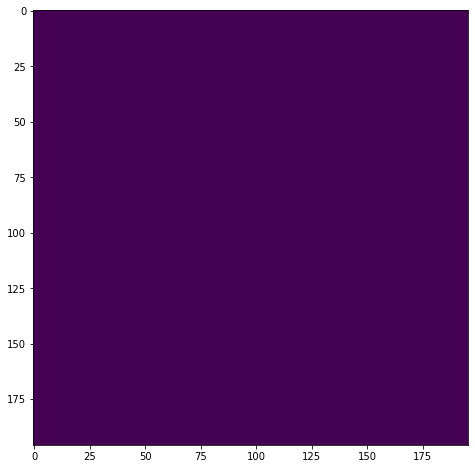

In [74]:
plt.figure(figsize=(8,8))
plt.imshow(approximation)